# LiH prototype - energy & rdm1

In [1]:
import pyscf
from pyscf import gto, scf, dft, ao2mo, fci
import numpy as np
import scipy.linalg as lin
import matplotlib.pyplot as plt

In [2]:
HARTREE_TO_eV = 27.311285

In [3]:
1.0/(0.3166808991e-5*27.311285)

11562.0807045062

In [4]:
npoints = 30
R_begin=0.5
R_end=4.5
R = np.linspace(start=R_begin,stop=R_end,num=npoints)

In [5]:
def get_entropy(mf,mo_occ=None):
    if mo_occ is None:
        f = mf.get_occ()/2
    else:
        f = mo_occ
    #print(f)
    f = f[(f>0) & (f<1)]
    return -2*(f*np.log(f) + (1-f)*np.log(1-f)).sum()

In [34]:
def run_rks(mol_str,smear=False,tau=500,basis='cc-pVTZ'):
    mol = gto.M(atom=mol_str, basis=basis)
    mol.smearing = smear
    mol.tau = tau
    mf = scf.RKS(mol)
    mf.xc='PBE'
    mf.run()
    h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
    rdm1=mf.make_rdm1()
    T = mf.mol.intor_symmetric('int1e_kin')
    Ekin = np.einsum('pq,qp', T, rdm1)*HARTREE_TO_eV
    #print("Ts: ", Ekin)
    #d = np.zeros(h1.shape[0])
    s = mf.get_occ()
    #for i in np.arange(h1.shape[0]):
    #    d[i] = h1[i,i]
    return s, mf, Ekin, mf.energy_tot()*HARTREE_TO_eV

In [46]:
def run_fci(mol_str,basis='cc-pVDZ'):
    mol = gto.M(atom=mol_str, basis=basis)
    mf = scf.RHF(mol)
    mf.run()
    norb=np.shape(mf.get_occ())[0]
    h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
    T = mf.mo_coeff.T.dot(mf.mol.intor_symmetric('int1e_kin')).dot(mf.mo_coeff)
    eri = ao2mo.kernel(mol, mf.mo_coeff)
    cisolver = fci.direct_spin1.FCI(mol)
    e, ci = cisolver.kernel(h1, eri, h1.shape[1], mol.nelec, ecore=mol.energy_nuc())
    rdm1=cisolver.make_rdm1(fcivec=ci,norb=norb,nelec=mol.nelec)
    Ekin = np.einsum('pq,qp', T, rdm1)*HARTREE_TO_eV
    #print("exact T: ", Ekin)
    #d = np.zeros(h1.shape[0])
    s = lin.eigh(rdm1)[0]
    #s = np.zeros(h1.shape[0])
    #for i in np.arange(h1.shape[0]):
    #    #d[i] = h1[i,i]
    #    s[i] = rdm1[i,i]
    return s, mf, Ekin, e*HARTREE_TO_eV


In [8]:
smear = False
occupations_KS = []
energies_KS = []
calculations_KS = []
Ekin_KS = []
ener_KS = []
for i in np.arange(npoints):
    mol_str = "Li 0 0 0; H 0 0 "+str(R[i])
    s, mf, Ekin, e = run_rks(mol_str=mol_str, smear=smear)
    occupations_KS.append(s)
    calculations_KS.append(mf)
    Ekin_KS.append(Ekin)
    ener_KS.append(e)

converged SCF energy = -7.27450810177158
converged SCF energy = -7.59895821108364
converged SCF energy = -7.78997868302774
converged SCF energy = -7.90470186625178
converged SCF energy = -7.97295077195478
converged SCF energy = -8.01217944488552
converged SCF energy = -8.03325388161043
converged SCF energy = -8.04295112405662
converged SCF energy = -8.04553824310603
converged SCF energy = -8.04373974723759
converged SCF energy = -8.0392987409936
converged SCF energy = -8.03332518078741
converged SCF energy = -8.02653361398826
converged SCF energy = -8.01939106323124
converged SCF energy = -8.01220608161364
converged SCF energy = -8.00518119982346
converged SCF energy = -7.99844561075707
converged SCF energy = -7.99207713953026
converged SCF energy = -7.98611771591676
converged SCF energy = -7.98058446443004
converged SCF energy = -7.97547766981521
converged SCF energy = -7.97078656278751
converged SCF energy = -7.96649341378398
converged SCF energy = -7.96257618590834
converged SCF ene

In [30]:
tau = 3500 #11562.0807045062 #KT=1eV
smear = True
occupations_KS_tau = []
energies_KS_tau = []
calculations_KS_tau = []
Ekin_KS_tau = []
ener_KS_tau = []

for i in np.arange(npoints):
    mol_str = "Li 0 0 0; H 0 0 "+str(R[i])
    s, mf, Ekin, e = run_rks(mol_str=mol_str,tau=tau,smear=smear)
    occupations_KS_tau.append(s)
    calculations_KS_tau.append(mf)
    if smear:
        mTS=-0.3166808991e-5*tau*get_entropy(mf)*HARTREE_TO_eV
    else:
        mTS = 0.0
    print(mTS)
    Ekin_KS_tau.append(Ekin)
    ener_KS_tau.append(e+mTS)

converged SCF energy = -7.26492203991329
-0.4275247392906264
converged SCF energy = -7.59328516594548
-0.20385153915378312
converged SCF energy = -7.78702753475712
-0.09836053523395201
converged SCF energy = -7.90284697318104
-0.06033296488960728
converged SCF energy = -7.9714582215622
-0.04819050734050675
converged SCF energy = -8.01072964818776
-0.046816554703851786
converged SCF energy = -8.03166063663848
-0.05168601703691715
converged SCF energy = -8.04106385951082
-0.06171461334217284
converged SCF energy = -8.04320726679389
-0.07706590253228857
converged SCF energy = -8.04081149260829
-0.09819818954043719
converged SCF energy = -8.03563155024569
-0.12521723653591615
converged SCF energy = -8.02881371859923
-0.15755307701523694
converged SCF energy = -8.0211260414237
-0.19407081507370863
converged SCF energy = -8.01309046191572
-0.23343655449381628
converged SCF energy = -8.00505983294377
-0.27442936015155167
converged SCF energy = -7.99726655446888
-0.31607634016732566
converged 

In [47]:
occupations_FCI = []
energies_FCI = []
calculations_FCI = []
Ekin_FCI = []
ener_FCI = []
for i in np.arange(npoints):
    mol_str = "Li 0 0 0; H 0 0 "+str(R[i])
    s, mf, Ekin, e = run_fci(mol_str=mol_str)
    occupations_FCI.append(s)
    calculations_FCI.append(mf)
    Ekin_FCI.append(Ekin)
    ener_FCI.append(e)


converged SCF energy = -7.15955674837856
converged SCF energy = -7.50341431065801
converged SCF energy = -7.70803613021059
converged SCF energy = -7.83120045108855
converged SCF energy = -7.9043362261742
converged SCF energy = -7.94650947923482
converged SCF energy = -7.96945659771586
converged SCF energy = -7.98036142532396
converged SCF energy = -7.98365674042903
converged SCF energy = -7.98213578365709
converged SCF energy = -7.97758864872824
converged SCF energy = -7.97117781563225
converged SCF energy = -7.9636679156875
converged SCF energy = -7.95556693035113
converged SCF energy = -7.9472138600137
converged SCF energy = -7.93883422478843
converged SCF energy = -7.93057603590793
converged SCF energy = -7.92253378985779
converged SCF energy = -7.91476501407374
converged SCF energy = -7.9073020000269
converged SCF energy = -7.90016021210922
converged SCF energy = -7.8933442479159
converged SCF energy = -7.88685194614069
converged SCF energy = -7.88067711534532
converged SCF energy 

In [48]:
occupations_FCI = np.array(occupations_FCI,dtype=np.float)
occupations_KS = np.array(occupations_KS,dtype=np.float)
occupations_KS_tau = np.array(occupations_KS_tau,dtype=np.float)
ener_FCI = np.array(ener_FCI,dtype=np.float)
ener_KS = np.array(ener_KS,dtype=np.float)
ener_KS_tau = np.array(ener_KS_tau,dtype=np.float)
Ekin_FCI = np.array(Ekin_FCI,dtype=np.float)
Ekin_KS = np.array(Ekin_KS,dtype=np.float)
Ekin_KS_tau = np.array(Ekin_KS_tau,dtype=np.float)
De_FCI = ener_FCI[-1]-np.min(ener_FCI)
De_KS = ener_KS[-1]-np.min(ener_KS)
De_KS_tau = ener_KS_tau[-1]-np.min(ener_KS_tau)

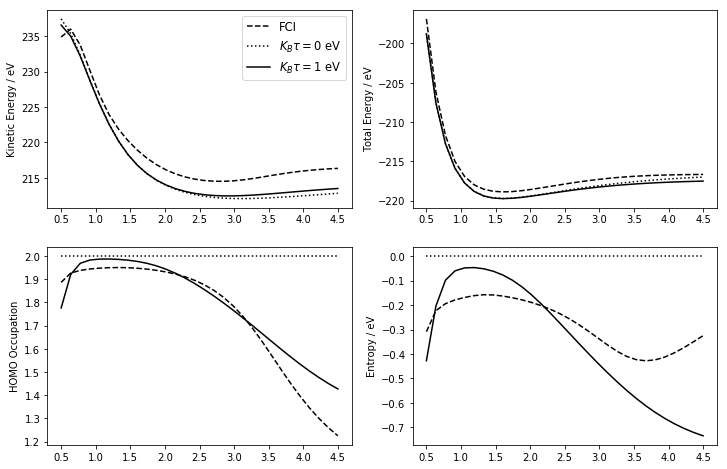

In [49]:
font=11.5
fig, ax = plt.subplots(2,2,figsize=(12,8))
#
ax[0,0].set_ylabel("Kinetic Energy / eV")
ax[0,0].plot(R,Ekin_FCI,label=r'FCI',color='black',linestyle='--')
ax[0,0].plot(R,Ekin_KS,label=r'$K_B\tau = 0$ eV',color='black',linestyle=':')
ax[0,0].plot(R,Ekin_KS_tau,label=r'$K_B\tau = 1$ eV',color='black',linestyle='-')
#
ax[0,1].set_ylabel("Total Energy / eV")
ax[0,1].plot(R,ener_FCI,label=r'FCI',color='black',linestyle='--')
ax[0,1].plot(R,ener_KS,label=r'$K_B\tau = 0$ eV',color='black',linestyle=':')
ax[0,1].plot(R,ener_KS_tau,label=r'$K_B\tau = 1$ eV',color='black',linestyle='-')
#
ax[1,0].set_ylabel("HOMO Occupation")
ax[1,0].plot(R,occupations_FCI[:,-2],label=r'FCI',color='black',linestyle='--')
ax[1,0].plot(R,occupations_KS[:,1],label=r'$K_B\tau = 0$ eV',color='black',linestyle=':')
ax[1,0].plot(R,occupations_KS_tau[:,1],label=r'$K_B\tau = 1$ eV',color='black',linestyle='-')
#ax[1,0].set_ylim([0.5,2.5])
#
ax[1,1].set_ylabel("Entropy / eV")
entropy_KS = np.zeros(npoints)
entropy_KS_tau = np.zeros(npoints)
entropy_FCI = np.zeros(npoints)
for i in range(npoints):
    #entropy_KS[i]=-0.3166808991e-5*tau*get_entropy(calculations_KS_tau[i])
    entropy_KS_tau[i]=-0.3166808991e-5*tau*get_entropy(calculations_KS_tau[i])*HARTREE_TO_eV
    entropy_FCI[i]=-0.3166808991e-5*tau*get_entropy(calculations_FCI[i],occupations_FCI[i,:])*HARTREE_TO_eV

ax[1,1].plot(R,entropy_FCI,label=r'FCI',color='black',linestyle='--')
ax[1,1].plot(R,entropy_KS,label=r'$K_B\tau = 0$ eV',color='black',linestyle=':')
ax[1,1].plot(R,entropy_KS_tau,label=r'$K_B\tau = 1$ eV',color='black',linestyle='-')

ax[0,0].legend(fontsize=font)
#for i in 0, 1:
#    for j in 0, 1:
#        ax[i,j].legend(fontsize=font)
plt.show()

In [50]:
print(De_KS-De_FCI,De_KS_tau-De_FCI,De_FCI)

0.5049454585918909 0.0014190586194615662 2.224695571502906


# prototyping natural orbitals

In [13]:
SVD = lin.svd

In [14]:
U, s, Vh = SVD(a=rdm1)

NameError: name 'rdm1' is not defined

In [ ]:
h1_natural = np.dot(Vh.T, np.dot(h1, U.T))

In [ ]:
d = np.zeros(h1_natural.shape[0])
s = np.zeros(h1_natural.shape[0])
for i in np.arange(h1_natural.shape[0]):
    d[i] = h1_natural[i,i]
    s[i] = rdm1[i,i]

In [ ]:
plt.scatter(x=d,y=s)
plt.show()

In [ ]:
from scipy.optimize import minimize

In [ ]:
minimize()